In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn

In [2]:
# Define the datapoint that is going to be used to feed
# into the linear regressor to create the function that
# updates the satisfaction score of the worker
# updateSatisf(ratio_sal): produces the satisfactory score of the worker
# based on the ratio of actual salary and expected salary, the higher the 
# ratio_sal, the lower 
# input: ratio_sal: a number between 0 to 2
ratio_sal = np.linspace(0, 2, 100).reshape(-1,1)
ratio_sal[50] = 1.0
sat_score = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.4, 1, 2, 3, 4,
                     5, 6, 7, 7, 8, 8, 9, 10, 11, 12, 13, 14, 15, 
                     16, 17, 18, 19, 20, 20, 21, 22.2, 23, 24, 25,
                     30, 31, 32, 34, 36, 37, 39, 40, 42, 43, 44, 45,
                     46, 47, 48, 49, 50, 60, 65, 66, 67, 68, 69, 70,
                     71, 72, 73, 74, 74, 75, 76, 77, 78, 79, 80, 85, 
                     86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99,
                     100, 100, 100, 100, 98, 93, 92, 91, 90, 86, 85, 86,
                     87, 88, 89, 90, 85]).reshape(-1,1)


In [3]:
# Define the training the testing data
np.random.seed(3)
idx = np.arange(len(ratio_sal))

train_idx = idx[:int(100*0.8)]
test_idx = idx[int(100*0.8):]

x_train, y_train = ratio_sal[train_idx], sat_score[train_idx]
x_test, y_test = ratio_sal[test_idx], sat_score[test_idx]

In [4]:
linr = LinearRegression()
linr.fit(x_train, y_train)
print(linr.intercept_, linr.coef_[0])
linr_pred = linr.predict(x_test)
linr_train = linr.predict(x_train)

[-11.39057635] [66.67649386]


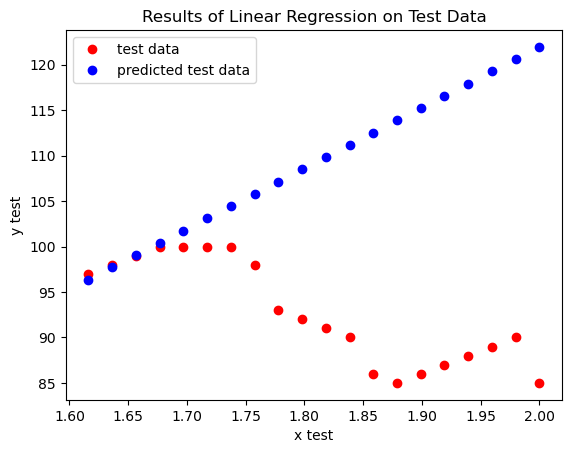

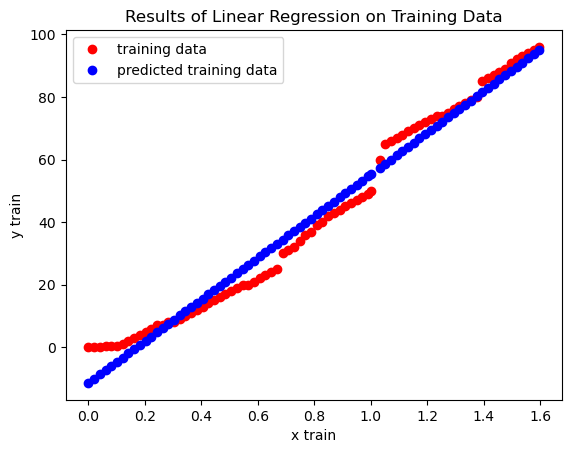

In [5]:
plt.figure()
plt.plot(x_test, y_test, 'ro', label = 'test data')
plt.plot(x_test, linr_pred,'bo', label = 'predicted test data')
plt.title('Results of Linear Regression on Test Data')
plt.xlabel('x test')
plt.ylabel('y test')
plt.legend()
plt.show()

plt.figure()
plt.plot(x_train, y_train, 'ro', label = 'training data')
plt.plot(x_train, linr_train, 'bo', label = 'predicted training data')
plt.title('Results of Linear Regression on Training Data')
plt.xlabel('x train')
plt.ylabel('y train')
plt.legend()
plt.show()

# Pytorch Version for Leveraging MPS on MAC

In [16]:
torch.manual_seed(36)
# Define the devices
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
# uncomment the following for windows PC
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Define the datasets
ratio_sal = np.linspace(0, 2, 100).reshape(-1,1)
ratio_sal[50] = 1.0
sat_score = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.4, 1, 2, 3, 4,
                     5, 6, 7, 7, 8, 8, 9, 10, 11, 12, 13, 14, 15, 
                     16, 17, 18, 19, 20, 20, 21, 22.2, 23, 24, 25,
                     30, 31, 32, 34, 36, 37, 39, 40, 42, 43, 44, 45,
                     46, 47, 48, 49, 50, 60, 65, 66, 67, 68, 69, 70,
                     71, 72, 73, 74, 74, 75, 76, 77, 78, 79, 80, 85, 
                     86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99,
                     100, 100, 100, 100, 98, 93, 92, 91, 90, 86, 85, 86,
                     87, 88, 89, 90, 85]).reshape(-1,1)
N = 100

idx = np.arange(100)
np.random.shuffle(idx)

train_idx = idx[:int(N * 0.8)]
test_idx = idx[int(N * 0.8):]

x_train, y_train = ratio_sal[train_idx], sat_score[train_idx]
x_test, y_test = ratio_sal[test_idx], sat_score[test_idx]

In [17]:
x_train_tensor = torch.as_tensor(x_train).float().to(device)
y_train_tensor = torch.as_tensor(y_train).float().to(device)
# check if the tensor is to mps
print(x_train_tensor.type(), y_train_tensor.type())

torch.mps.FloatTensor torch.mps.FloatTensor


In [25]:
# This time we use two linear layers
LR_model = nn.Sequential()
LR_model.add_module('layer1', nn.Linear(1, 1))
LR_model.to(device)
LR_model.state_dict()

loss_fn = nn.MSELoss(reduction = 'mean')

lr = 0.1
optimizer = optim.SGD(LR_model.parameters(), lr = 0.1)

In [26]:
n_epochs = 1000

for epochs in range(n_epochs):
    LR_model.train()

    LR_pred = LR_model(x_train_tensor)

    loss = loss_fn(LR_pred, y_train_tensor)
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

(LR_model.state_dict())

OrderedDict([('layer1.weight', tensor([[56.4239]], device='mps:0')),
             ('layer1.bias', tensor([-4.9276], device='mps:0'))])

In [27]:
x_test_tensor = torch.as_tensor(x_test).float().to(device)
y_pred = LR_model(x_test_tensor)
y_pred_np = y_pred.cpu().detach().numpy()

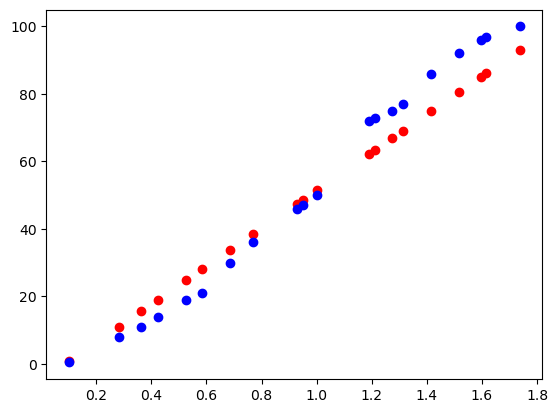

In [28]:
plt.figure()
plt.plot(x_test, y_pred_np, 'ro')
plt.plot(x_test, y_test, 'bo')

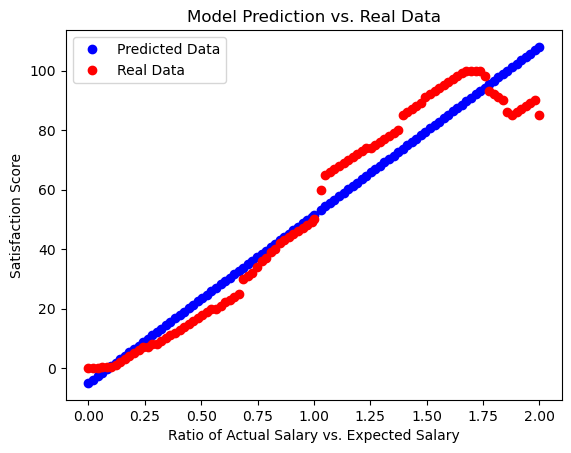

In [33]:
ratio_sal_tensor = torch.as_tensor(ratio_sal).float().to(device)
pred_whole = LR_model(ratio_sal_tensor)
pred_whole_np = pred_whole.cpu().detach().numpy()
plt.figure()
plt.plot(ratio_sal, pred_whole_np, 'bo', label = 'Predicted Data')
plt.plot(ratio_sal, sat_score, 'ro', label = 'Real Data')
plt.title('Model Prediction vs. Real Data')
plt.xlabel('Ratio of Actual Salary vs. Expected Salary')
plt.ylabel('Satisfaction Score')
plt.legend(loc = 'upper left')
plt.show()